In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
#importing data
Staller5ADlib = pd.read_csv("data/Staller2022_5AD_library.csv")
Staller_p53AD = pd.read_csv("data/Staller2022_p53AD.csv")
Staller_predictedAD = pd.read_csv("data/Staller2022_predicted_AD.csv")
ChoiADs = pd.read_csv("data/tf_effectordomains.csv")

aa_length_cutoff = 20

ChoiADs = ChoiADs[ChoiADs["Domain type"] == "AD"]
ChoiADs = ChoiADs.set_index("Effector domain ID")[["Sequence", "Activity (H, M or L)"]]
ChoiADs = ChoiADs[[len(x) > aa_length_cutoff for x in ChoiADs["Sequence"]]]


Staller5ADlib_zscores = Staller5ADlib[["Biological_Replicate_1_Activity", "Biological_Replicate_2_Activity", "Biological_Replicate_3_Activity", "Biological_Replicate_4_Activity"]].apply(zscore)
Staller5ADlib["Activity_Zscore_mean"] = Staller5ADlib_zscores.mean(axis=1)

Staller5ADlib_select = Staller5ADlib[["ADseq", "Activity_Zscore_mean"]].rename({"ADseq": "Sequence"}, axis=1)
Staller5ADlib_select = Staller5ADlib_select[[len(x) >= aa_length_cutoff for x in Staller5ADlib_select["Sequence"]]]

Stallerp53AD_select = Staller_p53AD[["ADseq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ADseq": "Sequence"}, axis=1)
Stallerp53AD_select = Stallerp53AD_select[[len(x) >= aa_length_cutoff for x in Stallerp53AD_select["Sequence"]]]

Staller_predictedAD_select = Staller_predictedAD[["ProteinRegionSeq", "Activity_Zscore_mean", "Activity_Zscore_SEM"]].rename({"ProteinRegionSeq": "Sequence"}, axis=1)
Staller_predictedAD_select = Staller_predictedAD_select[[len(x) >= aa_length_cutoff for x in Staller_predictedAD_select["Sequence"]]]

choiAD_coA_finches = pd.read_csv("helperdata/ChoiADs_coA.csv", index_col=0)
staller5libAD_coA_finches = pd.read_csv("helperdata/Staller5libADs_coA.csv", index_col=0)
stallerP53AD_coA_finches = pd.read_csv("helperdata/StallerP53ADs_coA.csv", index_col=0)
stallerpredictedAD_coA_finches = pd.read_csv("helperdata/StallerPredictedADs_coA.csv", index_col=0)

def activity_category(finchesresult_df, AD_df, activitylabel):
    with_activity = finchesresult_df.merge(AD_df[[activitylabel]], left_on="Prot1", right_index=True, how="left")
    return with_activity

choiAD_coA_finches_activity = activity_category(choiAD_coA_finches, ChoiADs, "Activity (H, M or L)")
staller5libAD_coA_finches_activity = activity_category(staller5libAD_coA_finches, Staller5ADlib_select, "Activity_Zscore_mean")
stallerP53AD_coA_finches_activity = activity_category(stallerP53AD_coA_finches, Stallerp53AD_select, "Activity_Zscore_mean")
stallerPredictedADs_coA_finches_activity = activity_category(stallerpredictedAD_coA_finches, Staller_predictedAD_select, "Activity_Zscore_mean")

coAs = pd.read_csv("helperdata/coAs.csv", index_col=0)

In [4]:
#calculate correlation for each domain
def correlation_with_activity(df, activity_label, bydomain):
    if bydomain:
        outputdf = pd.DataFrame(index = coAs.index.to_list())
        for quantvar in ["Attractive e (mf)", "Repulsive e (mf)", "Total e (mf)", "Attractive e (cf)", "Repulsive e (cf)", "Total e (cf)"]:
            selectonly = df[["Prot2", quantvar, activity_label]].dropna()
            selectonly = selectonly.groupby("Prot2").agg(list)
            if activity_label != quantvar:
                outputdf[quantvar + " Pearson R"] = selectonly.apply(lambda row: stat.pearsonr(row[activity_label], row[quantvar])[0], axis=1)
                outputdf[quantvar + " Spearman R"] = selectonly.apply(lambda row: stat.spearmanr(row[activity_label], row[quantvar])[0], axis=1)
    else:
        outputdf = df.set_index(["Prot1", "Prot2"]).corr()
    return outputdf

In [5]:
#Check if any domains show correlation between interaction and activity: Answer - No
staller5lib_corrs = correlation_with_activity(staller5libAD_coA_finches_activity, "Activity_Zscore_mean", True)
stallerP53AD_corrs = correlation_with_activity(stallerP53AD_coA_finches_activity, "Activity_Zscore_mean", True)
stallerPredictedADs_corrs = correlation_with_activity(stallerPredictedADs_coA_finches_activity, "Activity_Zscore_mean", True)

staller5lib_corrs_highest = abs(staller5lib_corrs).max().max()
stallerP53AD_corrs_highest = abs(stallerP53AD_corrs).max().max()
stallerPredictedADs_corrs_highest = abs(stallerPredictedADs_corrs).max().max()

if staller5lib_corrs_highest >= 0.6:
    print("5Lib", abs(staller5lib_corrs).stack().idxmax(), staller5lib_corrs_highest)
if stallerP53AD_corrs_highest >= 0.6:
    print("P53", abs(stallerP53AD_corrs).stack().idxmax(), stallerP53AD_corrs_highest)
if stallerPredictedADs_corrs_highest >= 0.6:
    print("Predicted", abs(stallerPredictedADs_corrs).stack().idxmax(), stallerPredictedADs_corrs_highest)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


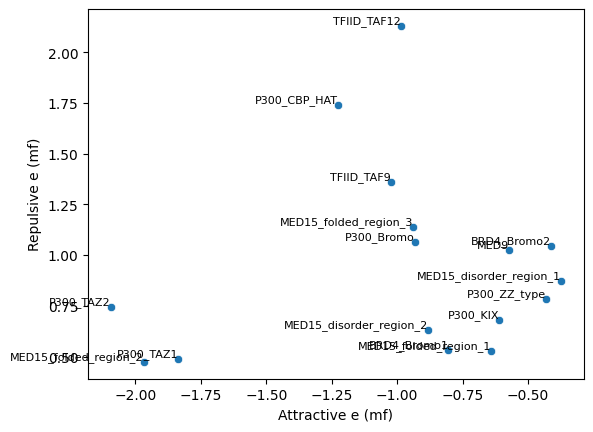

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


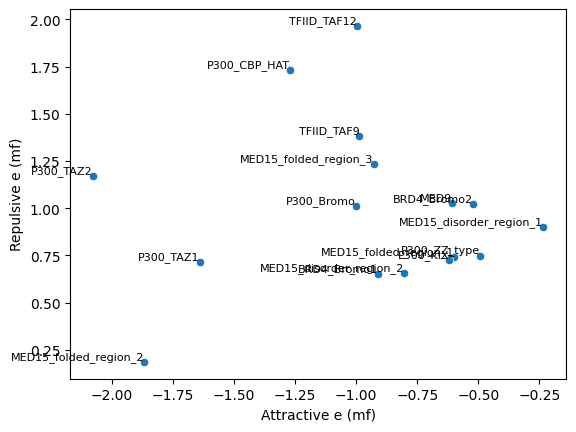

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


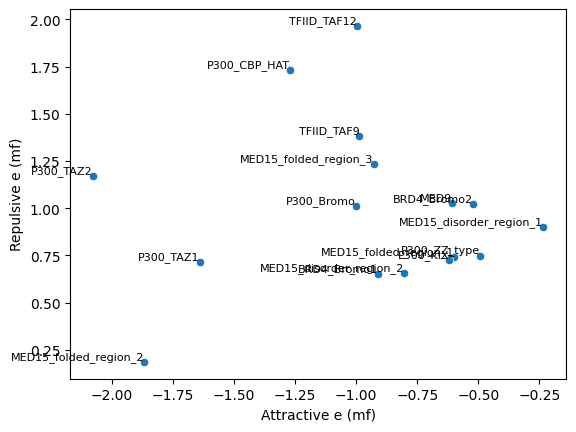

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/2349159013.py:2: FutureWarning: The provided callable <function mean at 0x12081d6c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)


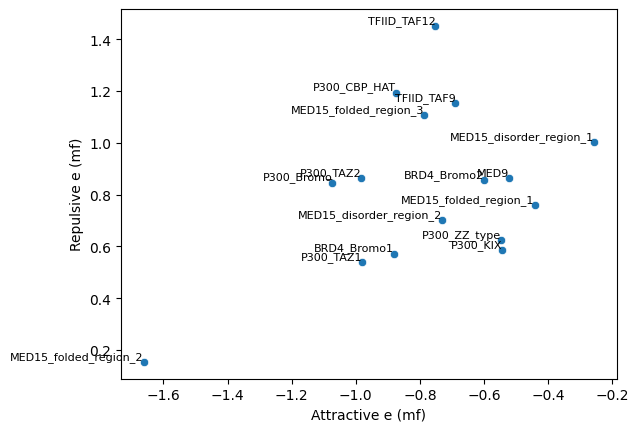

In [6]:
def plot_interaction_by_group(df, aggfunc, activity_label):
    mean_interaction_df = df.drop(["Prot1", activity_label], axis=1).groupby("Prot2").agg(aggfunc)
    mean_interaction_df

    x_label = "Attractive e (mf)"
    y_label = "Repulsive e (mf)"

    sns.scatterplot(mean_interaction_df, x = x_label, y = y_label)

    for i in range(len(mean_interaction_df)):
        plt.text(mean_interaction_df[x_label].iloc[i], mean_interaction_df[y_label].iloc[i], mean_interaction_df.index[i],
                fontsize=8, ha='right', va='bottom')
    plt.show()

plot_interaction_by_group(staller5libAD_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(stallerP53AD_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(stallerPredictedADs_coA_finches_activity, np.mean, activity_label = "Activity_Zscore_mean")
plot_interaction_by_group(choiAD_coA_finches_activity, np.mean, activity_label = "Activity (H, M or L)")


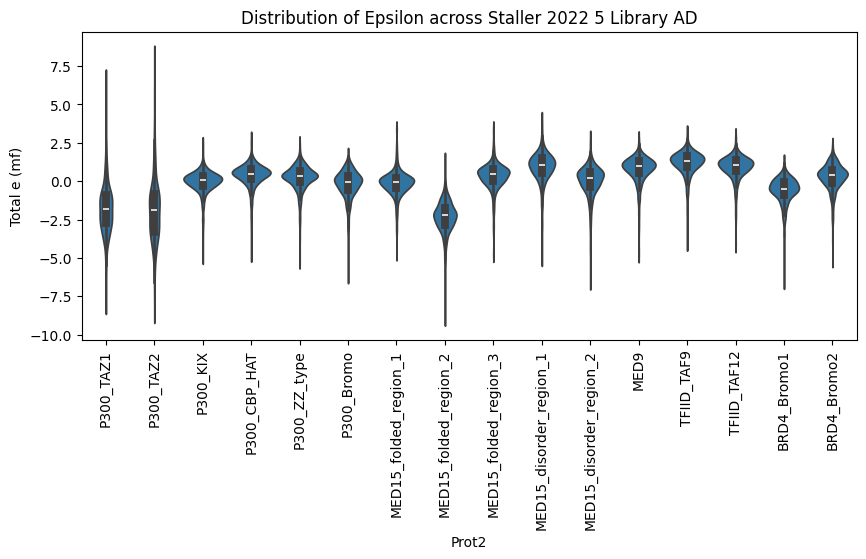

<Figure size 640x480 with 0 Axes>

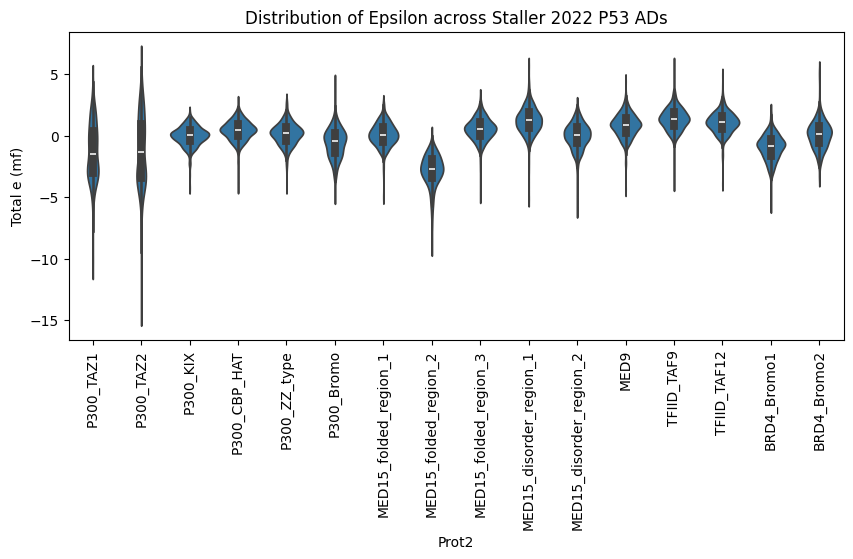

<Figure size 640x480 with 0 Axes>

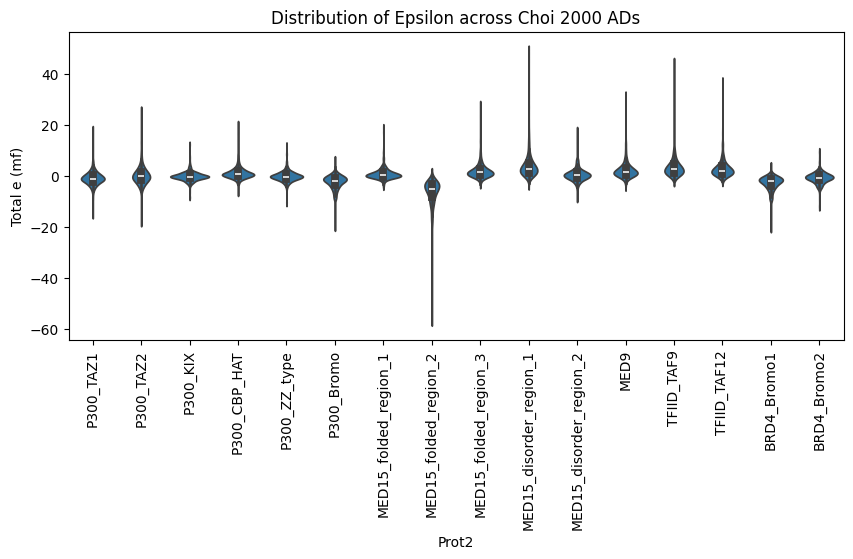

<Figure size 640x480 with 0 Axes>

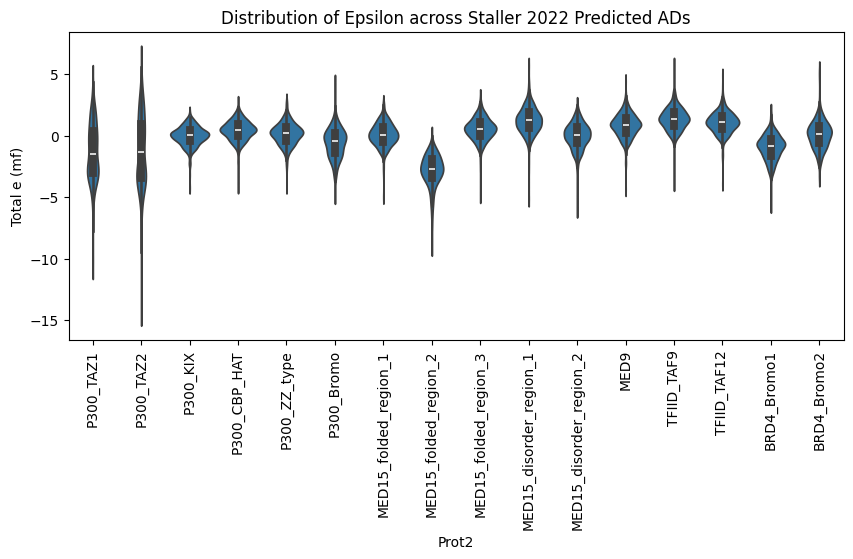

<Figure size 640x480 with 0 Axes>

In [126]:
plt.figure(figsize=(10, 4))
sns.violinplot(staller5libAD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 5 Library AD")
plt.savefig("figures/AD_coA_epsilon_dist_5Lib_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(stallerP53AD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 P53 ADs")
plt.savefig("figures/AD_coA_epsilon_dist_P53_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(choiAD_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Choi 2000 ADs")
plt.savefig("figures/AD_coA_epsilon_dist_Choi2000_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(10, 4))
sns.violinplot(stallerPredictedADs_coA_finches_activity.reset_index(), x = "Prot2", y = "Total e (mf)")
plt.xticks(rotation=90)
plt.title("Distribution of Epsilon across Staller 2022 Predicted ADs")
plt.savefig("figures/AD_coA_epsilon_dist_Predicted_ADs.png", bbox_inches = "tight")
plt.show()
plt.clf()

---
# Look at motifs across ADs and CoAs

In [24]:
import regex as re
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [49]:
def count_patterns(df, sequence_col="Sequence"):
    regexterms = ["[WFYL]", "[DE]" ,"[SPQ]{3,}", "[WFYL]{3,}", "[WFYLSPQ]{5,}", "[WFYLSPQ]{7,}", "[WFYLDE]{5,}", "[WFYLDE]{3,}", "QQQ", "SSS", "PPP", "L..LL", "[PQL]{3,}"]

    def get_regex_counts(sequence):
        regexdict = {}
        for regexterm in regexterms:
            regexdict[regexterm] = len(re.findall(regexterm, sequence))
        return regexdict

    metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
    return df.join(metrics_df)

def compute_protein_metrics(df, sequence_col="Sequence", pH=7.0):
    def analyze_sequence(seq):
        protein = ProteinAnalysis(seq)
        return {
            "Molecular Weight": protein.molecular_weight(),
            "Net Charge at pH {:.1f}".format(pH): protein.charge_at_pH(pH),
            "Isoelectric Point (pI)": protein.isoelectric_point(),
            "Hydrophobicity (GRAVY)": protein.gravy(),
            "Instability Index": protein.instability_index(),
        }
    
    metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)
    return df.join(metrics_df)


In [50]:
Staller5ADlib_select_features = compute_protein_metrics(count_patterns(Staller5ADlib_select))
Staller5ADlib_select_features

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1215623373.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1215623373.py:24: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


,Sequence,Activity_Zscore_mean,[WFYL],[DE],"[SPQ]{3,}","[WFYL]{3,}","[WFYLSPQ]{5,}","[WFYLSPQ]{7,}","[WFYLDE]{5,}","[WFYLDE]{3,}",QQQ,SSS,PPP,L..LL,"[PQL]{3,}",Molecular Weight,Net Charge at pH 7.0,Isoelectric Point (pI),Hydrophobicity (GRAVY),Instability Index
0,ALLGQSMAASGLPQLTSYACAVNAPIQGSANLLQGAALLAALAQVN,-0.569574,10,0,0,0,0,0,0,0,0,0,0,0,2,4453.1027,-0.215025,5.560752,0.763043,52.880435
1,ALLGQSMDESGLPQLTSYDCEVNAPIQGSANLLQGEELLAALDQVN,0.694728,10,7,0,0,0,0,0,1,0,0,0,0,2,4817.2756,-7.200421,4.050028,-0.043478,52.126087
2,DDDIDLPMDPRDLDDLMDFGDDGEGAEPDAGGDFEDLDFDMELDDE,-0.324962,8,23,0,0,0,0,3,4,0,0,0,0,0,5124.1571,-22.200445,4.050028,-1.100000,14.389130
3,DDDIDLPMDPRDLDDLMDFGDDGEGAEPSAGGQFESLTFDMELTSE,-0.274816,8,17,0,0,0,0,1,2,0,0,0,0,0,5025.2016,-16.207170,4.050028,-0.802174,28.723913
4,DDFIDEEVLMDLVIEMGLDRIKELPELWLGDDEFDFMDD,2.004356,10,16,0,1,0,0,1,4,0,0,0,0,0,4677.1488,-14.209656,4.050028,-0.228205,43.187179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,TKFIKKKVLMSLVIKMGLKRIKELPELWLGQNEFDFMTD,-0.383847,10,5,0,1,0,0,0,2,0,0,0,0,0,4669.6583,2.405047,9.601357,-0.076923,45.966667
521,TKFIKKKVLMSLVIKMGLKRIKKLPKLWLGQNKFKFMTK,-0.491240,10,0,0,1,0,0,0,1,0,0,0,0,0,4693.0030,12.386199,11.608258,-0.128205,38.143590
522,TRFIRRRVLMSLVIRMGLRRIKELPELWLGQNEFDFMTD,-0.632829,10,5,0,1,0,0,0,2,0,0,0,0,0,4837.7387,2.410981,11.248331,-0.169231,86.956410
523,TRFIRRRVLMSLVIRMGLRRIKRLPRLWLGQNRFRFMTR,-0.486277,10,0,0,1,0,0,0,1,0,0,0,0,0,5001.1504,12.397078,11.999968,-0.297436,87.694872


In [51]:
coAS_features = compute_protein_metrics(count_patterns(coAs))
coAS_features

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1215623373.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(get_regex_counts).apply(pd.Series)
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_53008/1215623373.py:24: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  metrics_df = df[sequence_col].apply(analyze_sequence).apply(pd.Series)


,Sequence,[WFYL],[DE],"[SPQ]{3,}","[WFYL]{3,}","[WFYLSPQ]{5,}","[WFYLSPQ]{7,}","[WFYLDE]{5,}","[WFYLDE]{3,}",QQQ,SSS,PPP,L..LL,"[PQL]{3,}",Molecular Weight,Net Charge at pH 7.0,Isoelectric Point (pI),Hydrophobicity (GRAVY),Instability Index
P300_TAZ1,DPEKRKLIQQQLVLLLHAHKCQRREQANGEVRQCNLPHCRTMKNVL...,10,5,1,1,0,0,0,1,1,0,0,1,3,10074.6634,8.372995,9.301837,-0.678161,54.435632
P300_TAZ2,GDSRRLSIQRCIQSLVHACQCRNANCSLPSCQKMKRVVQHTKGCKR...,8,2,0,0,0,0,0,0,0,0,0,0,0,9202.9141,11.974966,9.388805,-0.343902,75.313415
P300_KIX,GIRKQWHEDITQDLRNHLVHKLVQAIFPTPDPAALKDRRMENLVAY...,15,13,0,0,0,0,0,2,0,0,0,0,0,9520.7400,0.130075,7.107625,-0.813750,40.765000
P300_CBP_HAT,KFSAKRLPSTRLGTFLENRVNDFLRRQNHPESGEVTVRVVHASDKT...,66,56,3,0,0,0,0,13,0,0,1,0,2,43531.0460,3.804537,8.314826,-0.725729,48.140318
P300_ZZ_type,RFVYTCNECKHHVETRWHCTVCEDYDLCITCYNTKNHDHKMEKLGLGLD,9,8,0,0,0,0,1,1,0,0,0,0,0,5903.6456,-1.851541,6.181263,-0.738776,55.451020
P300_Bromo,RQDPESLPFRQPVDPQLLGIPDYFDIVKSPMDLSTIKRKLDTGQYQ...,18,10,0,1,0,0,0,2,0,0,0,0,1,8837.9177,-1.234352,5.120818,-0.763014,41.120548
MED15_folded_region_1,MDVSGQETDWRSTAFRQKLVSQIEDAMRKAGVAHSKSSKDMESHVF...,10,10,0,0,0,0,0,1,0,0,0,0,0,8217.2571,1.859965,9.221058,-0.574648,39.214085
MED15_folded_region_2,ALQQQQQQQQFQQQQQAALQQQQQQQQQQQFQAQQSAMQQQFQAVV...,11,0,10,0,6,5,0,0,14,0,0,0,8,11372.2398,2.056388,11.001095,-1.764516,125.034409
MED15_folded_region_3,QQYLDKLKQLSKYIEPLRRMINKIDKNEDRKKDLSKMKSLLDILTD...,48,27,2,0,4,0,1,6,0,0,1,0,4,29345.7990,7.308777,8.964216,-0.420849,68.412355
MED15_disorder_region_1,KKSQASVSDPMNALQSLTGGPAAGAAGIGMPPRGPGQSLGGMGSLG...,7,1,1,0,1,0,0,0,0,0,1,0,2,8396.5092,1.846389,9.994356,-0.163218,58.951724


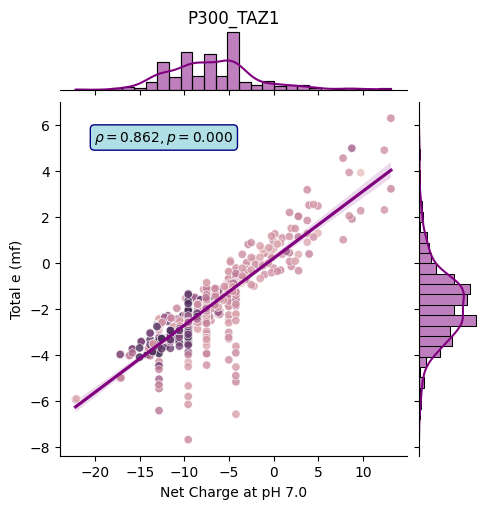

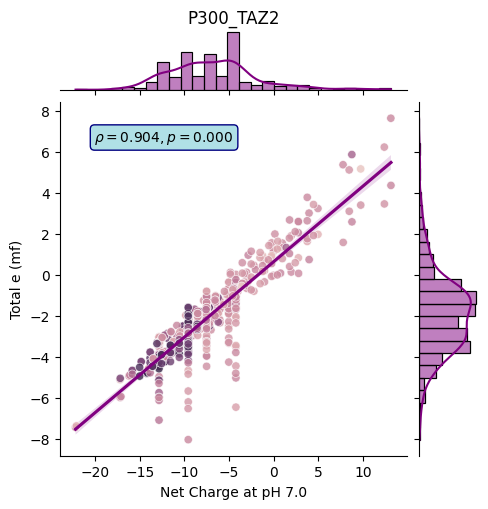

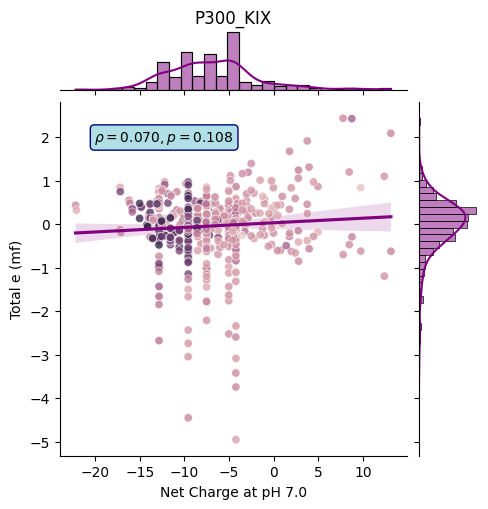

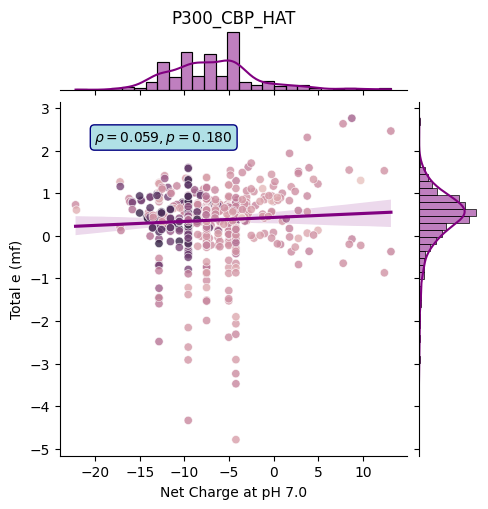

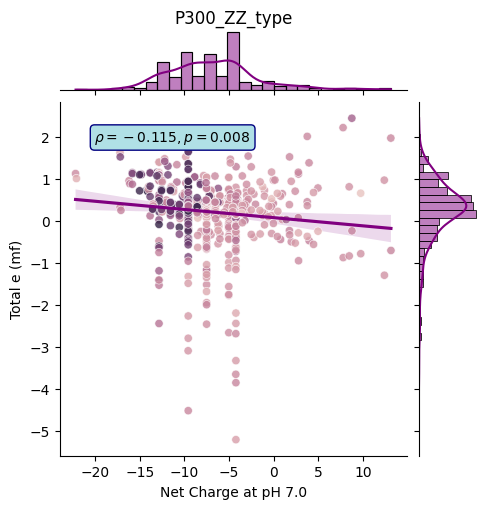

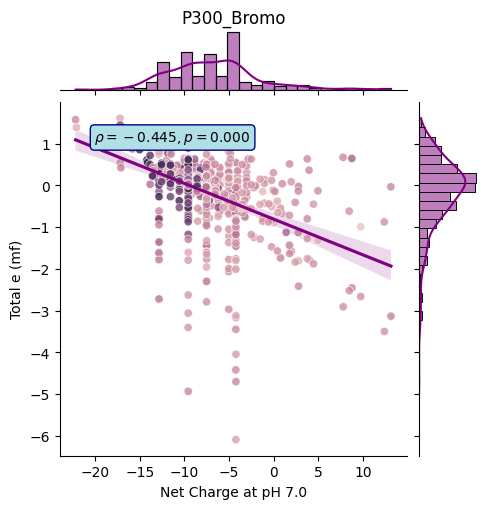

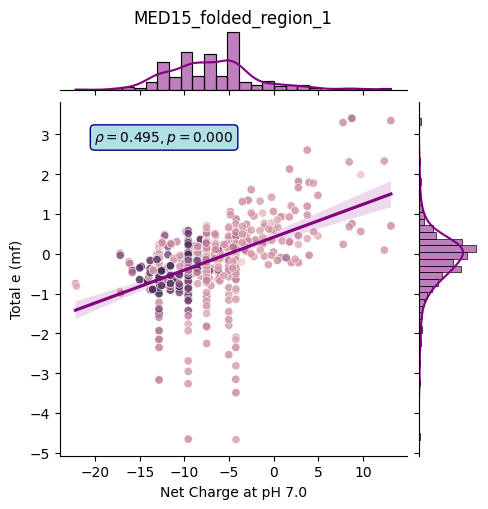

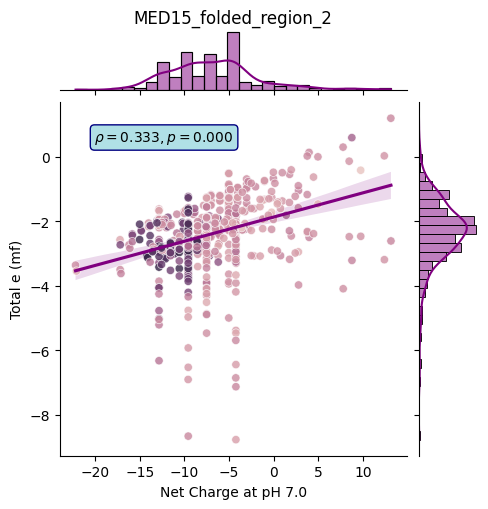

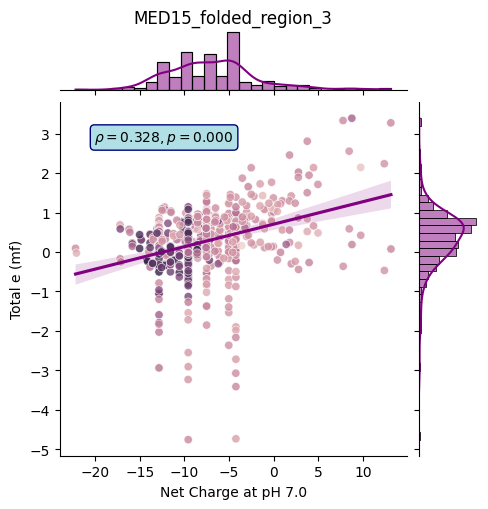

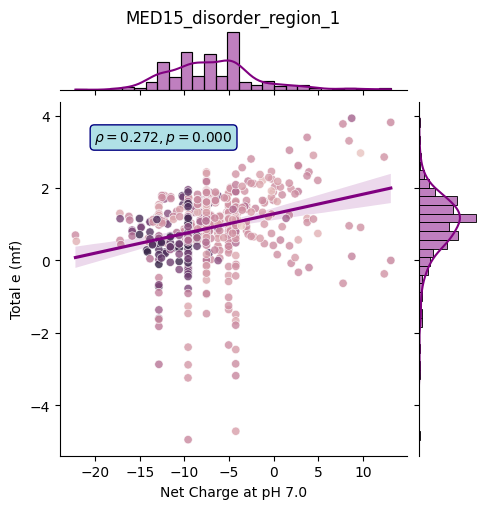

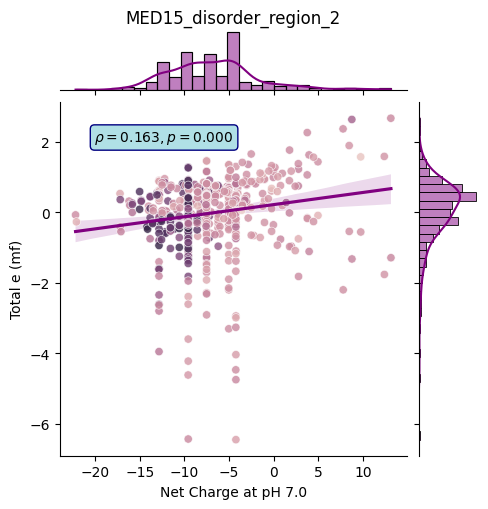

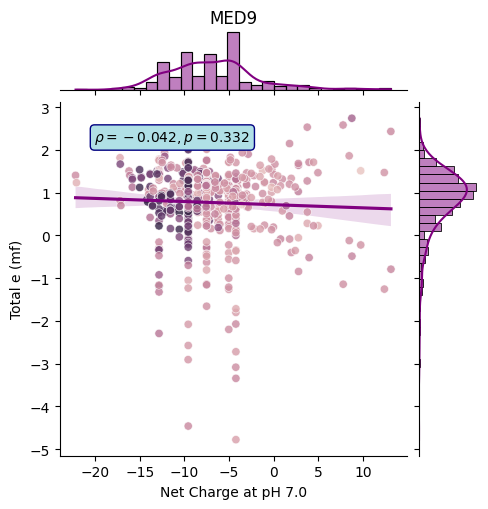

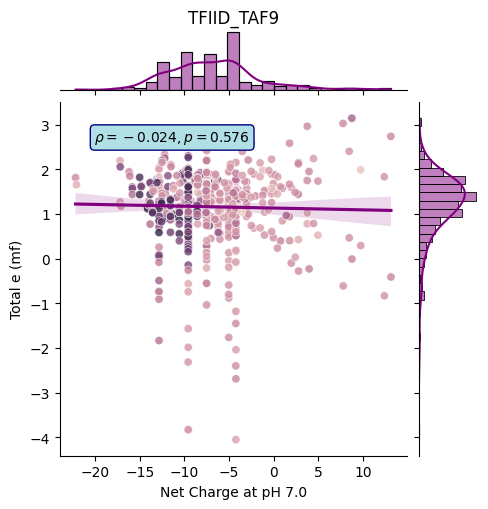

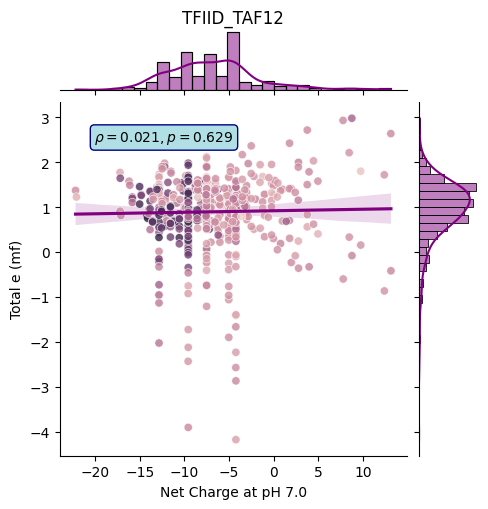

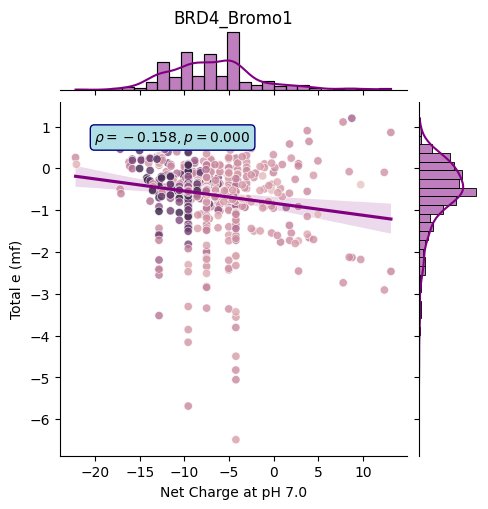

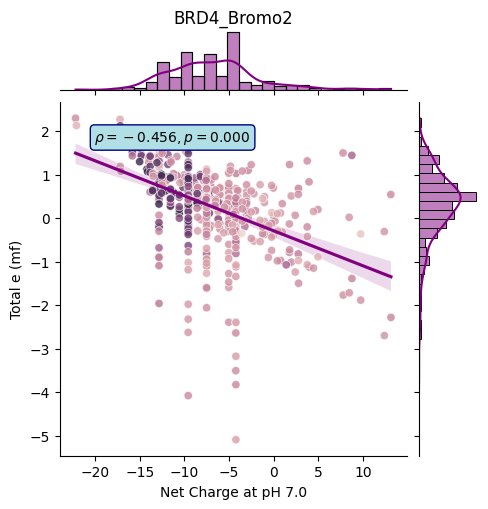

In [ ]:
x = "Net Charge at pH 7.0"
y = "Total e (mf)"

for coA in coAs.index.to_list():
    coA_only = staller5libAD_coA_finches_activity[staller5libAD_coA_finches_activity["Prot2"] == coA]
    coA_with_AD_properties = coA_only.merge(Staller5ADlib_select_features, left_on="Prot1", right_index=True)
    
    g = sns.jointplot(data = coA_with_AD_properties, x = x, y = y, kind='reg', scatter = False, color = "purple", height=5)
    ax_g_scatter = sns.scatterplot(data=coA_with_AD_properties, x = x, y = y, hue = "Activity_Zscore_mean_x", ax=g.ax_joint, alpha=0.8, legend=False)

    r, p = stat.pearsonr(coA_with_AD_properties[x], coA_with_AD_properties[y])
    g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    

    plt.title(coA, y = 1.2)
    plt.savefig("figures/{0}_AD_charge_vs_e.png".format(coA))
    plt.show()


In [48]:
staller5libAD_coA_finches_activity

,Prot1,Prot2,Attractive e (mf),Repulsive e (mf),Total e (mf),Attractive e (cf),Repulsive e (cf),Total e (cf),Activity_Zscore_mean
0,0.0,P300_TAZ1,-0.262649,0.604114,0.623567,-2.485323,1.010253,-1.692345,-0.569574
1,1.0,P300_TAZ1,-1.238875,NaN,-1.414504,-1.241867,0.500732,-1.737355,0.694728
2,2.0,P300_TAZ1,-4.252816,NaN,-5.930522,-2.195572,0.980606,-2.556359,-0.324962
3,3.0,P300_TAZ1,-3.058782,NaN,-4.027382,-1.743200,0.685370,-2.044642,-0.274816
4,4.0,P300_TAZ1,-2.694424,NaN,-3.975393,-2.550521,1.078211,-3.477108,2.004356
...,...,...,...,...,...,...,...,...,...
520,520.0,BRD4_Bromo2,-0.511421,0.764748,0.070172,-3.131017,NaN,-3.584528,-0.383847
521,521.0,BRD4_Bromo2,-0.894308,0.630315,-0.304229,-5.324346,NaN,-6.346751,-0.491240
522,522.0,BRD4_Bromo2,-0.821405,0.259560,-1.234596,-5.551011,NaN,-7.082677,-0.632829
523,523.0,BRD4_Bromo2,-1.653395,NaN,-2.694882,-9.762346,NaN,-12.820606,-0.486277


In [385]:
#combine all ADs
def pivot_activity_df(finchesdf, activitydf, dfname):
    pivotdf = finchesdf.pivot(index = "Prot1", columns="Prot2", values="Total e (mf)")
    pivotdf.index = [dfname + "_" + str(int(x)) for x in pivotdf.index.to_list()]
    activitydf_output = activitydf[["Activity_Zscore_mean"]]
    activitydf_output.index = [dfname + "_" + str(int(x)) for x in activitydf.index.to_list()]
    return pivotdf, activitydf_output

staller5lib_pivot, staller5lib_activity = pivot_activity_df(staller5libAD_coA_finches_activity, Staller5ADlib_select, "Staller5Lib")
stallerP53AD_pivot, stallerP53_activity = pivot_activity_df(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "StallerP53")
stallerPredicted_pivot, stallerPredicted_activity = pivot_activity_df(stallerPredictedADs_coA_finches_activity, Staller_predictedAD_select, "StallerPredicted")

all_AD_coA = pd.concat(
    [staller5lib_pivot,
    stallerP53AD_pivot,
    stallerPredicted_pivot
    ])

all_AD_coA_activity = pd.concat([
    staller5lib_activity,
    stallerP53_activity,
    stallerPredicted_activity
    ])

#dropna_activity
all_AD_coA_activity_dropna = all_AD_coA_activity["Activity_Zscore_mean"].dropna()
all_AD_coA_dropna = all_AD_coA.loc[all_AD_coA_activity_dropna.index]

stallerPredicted_activity_dropna = stallerPredicted_activity["Activity_Zscore_mean"].dropna()
stallerPredicted_pivot_dropna = stallerPredicted_pivot.loc[stallerPredicted_activity_dropna.index]

stallerP53_activity_dropna = stallerP53_activity["Activity_Zscore_mean"].dropna()
stallerP53AD_pivot_dropna = stallerP53AD_pivot.loc[stallerP53_activity_dropna.index]

print(len(stallerP53_activity_dropna), len(stallerP53AD_pivot_dropna))




440 440


/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/447237728.py:10: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  stallerP53AD_pivot, stallerP53_activity = pivot_activity_df(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "StallerP53")


---
# Running models

In [382]:
selected_features = staller5lib_pivot[["MED15_folded_region_2", "P300_TAZ1", "P300_TAZ2"]]

In [383]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

0.29516714346312645


<Axes: >

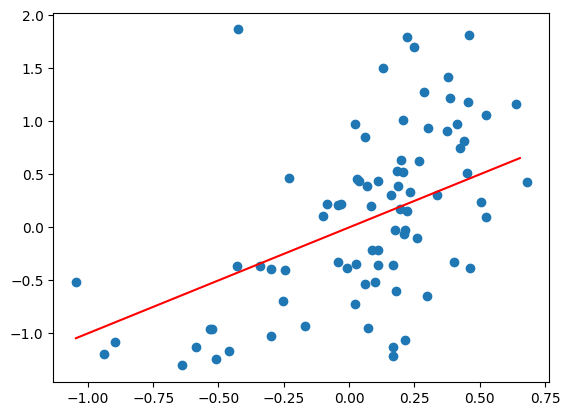

In [388]:
X_train, X_test, y_train, y_test = train_test_split(stallerPredicted_pivot_dropna, stallerPredicted_activity_dropna, test_size=0.2, random_state=42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X_train, y_train)

score = gpr.score(X_test, y_test)
print(score)

y_pred = gpr.predict(X_test)

plt.scatter(x = y_pred, y = y_test)
sns.lineplot(x = np.arange(min(y_pred), max(y_pred), 0.05), y = np.arange(min(y_pred), max(y_pred), 0.05), color="red")

0.4755220185172789
0.29638509885036834


<Axes: >

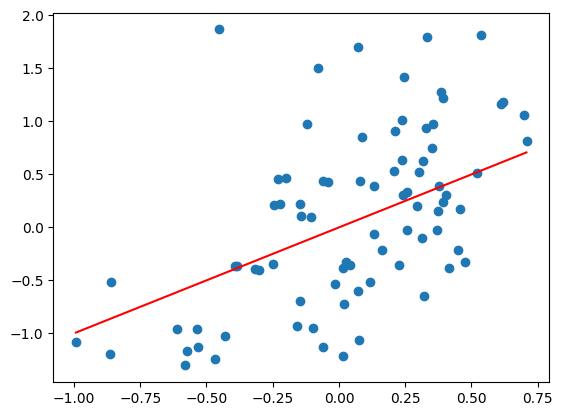

In [389]:
X_train, X_test, y_train, y_test = train_test_split(stallerPredicted_pivot_dropna, stallerPredicted_activity_dropna, test_size=0.2, random_state=42)

# 4️⃣ Train the Linear Regression model on polynomial features
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)
r2 = r2_score(y_test, y_pred)
print(r2)

plt.scatter(x = y_pred, y = y_test)
sns.lineplot(x = np.arange(min(y_pred), max(y_pred), 0.05), y = np.arange(min(y_pred), max(y_pred), 0.05), color="red")

In [361]:
#Clustering based on similarity across domains
def pivot_cluster(AD_coA_finchesdf, ADlibdf, plot, name):
    pivotdf = AD_coA_finchesdf.pivot(index="Prot1", columns="Prot2", values="Total e (mf)")
    kmeans = AgglomerativeClustering(n_clusters=10)
    pca = PCA(2) 
    clusterpred = kmeans.fit_predict(pivotdf)
    PCA_vals = pca.fit_transform(pivotdf)

    cluster_PCA_df = ADlibdf.copy()
    cluster_PCA_df[["PCA 1", "PCA 2"]] = PCA_vals
    cluster_PCA_df["Cluster"] = clusterpred

    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
        plt.title(name)
        ax1 = sns.boxplot(cluster_PCA_df, x = "Cluster", y = "Activity_Zscore_mean", ax = ax1)
        ax2 = sns.scatterplot(cluster_PCA_df, x = "PCA 1", y = "PCA 2", hue = "Cluster", alpha=0.5, ax = ax2)
        plt.show()

    return pivotdf, cluster_PCA_df

In [ ]:

pca = PCA(2) 
PCA_vals = pca.fit_transform(staller5libAD_coA_finches_activity)

cluster_PCA_df = Staller5ADlib_select.copy()
cluster_PCA_df[["PCA 1", "PCA 2"]] = PCA_vals

sns.scatterplot(cluster_PCA_df, x = "PCA 1", y = "PCA 2")

ValueError: could not convert string to float: 'P300_TAZ1'

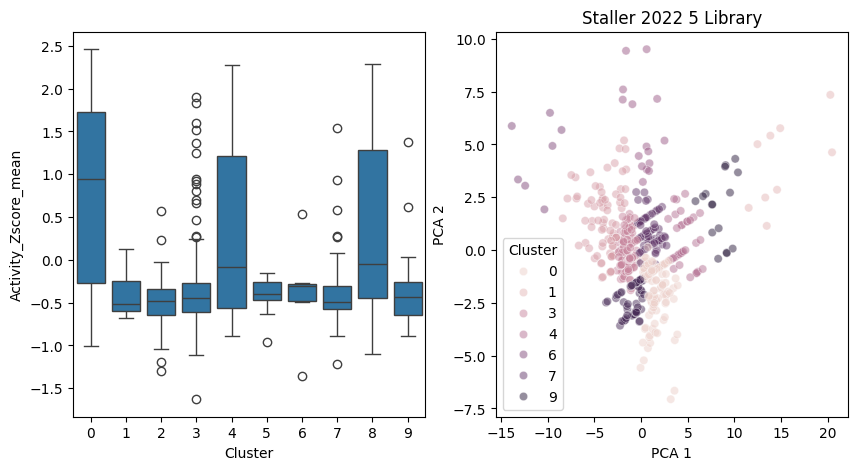

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_42817/3417607001.py:2: FutureWarning: The provided callable <function mean at 0x11240eac0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  stallerP53_pivotdf, stallerP53_cluster_PCA_df = pivot_cluster(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "Staller 2022 P53 Library")


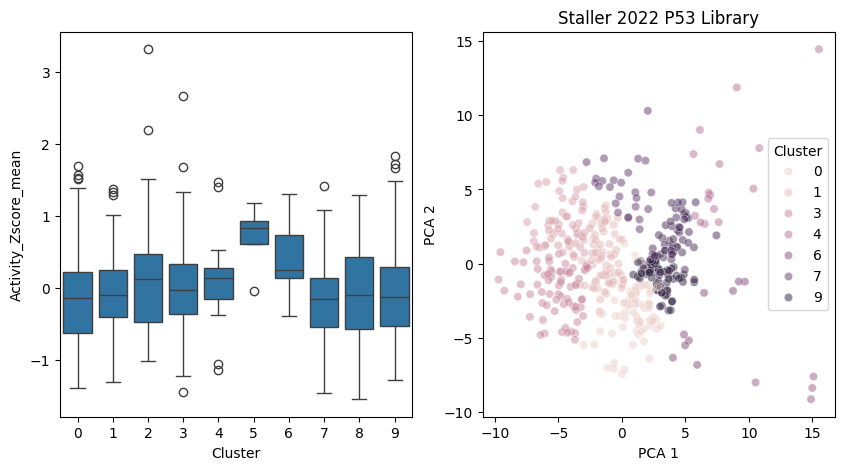

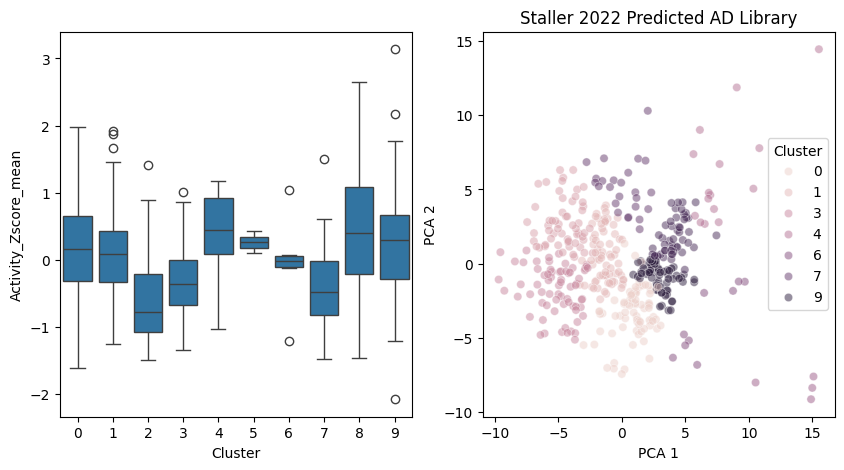

ValueError: Length of values (489) does not match length of index (7824)

In [257]:
staller5lib_pivotdf, staller5lib_cluster_PCA_df = pivot_cluster(staller5libAD_coA_finches_activity, Staller5ADlib_select, "Staller 2022 5 Library")
stallerP53_pivotdf, stallerP53_cluster_PCA_df = pivot_cluster(stallerP53AD_coA_finches_activity, stallerP53AD_coA_finches_activity[["Prot1", "Activity_Zscore_mean"]].groupby("Prot1").agg(np.mean), "Staller 2022 P53 Library")
stallerPredicted_pivotdf, stallerPredicted_cluster_PCA_df = pivot_cluster(stallerPredictedADs_coA_finches_activity, Staller_predictedAD_select, "Staller 2022 Predicted AD Library")
choi_pivotdf, choi_cluster_PCA_df = pivot_cluster(choiAD_coA_finches_activity, choiAD_coA_finches, "Choi 2000 ADs")

In [159]:
#most interacting ADs
attractiveADs = staller5libAD_coA_finches_activity[["Prot1", "Prot2", "Attractive e (mf)"]].sort_values("Attractive e (mf)")[:3000].groupby("Prot1").agg(list)
attractiveADs["Mean Attractive e"] = [np.mean(x) for x in attractiveADs["Attractive e (mf)"]]
attractiveADs["Num CoAs"] = [len(x) for x in attractiveADs["Prot2"]]
attractiveADs = attractiveADs.sort_values("Mean Attractive e")
attractiveADs = attractiveADs.merge(Staller5ADlib.loc[attractiveADs.index.to_list()][["Activity_Zscore_mean"]], left_index=True, right_index=True)

<Axes: xlabel='Mean Attractive e', ylabel='Activity_Zscore_mean'>

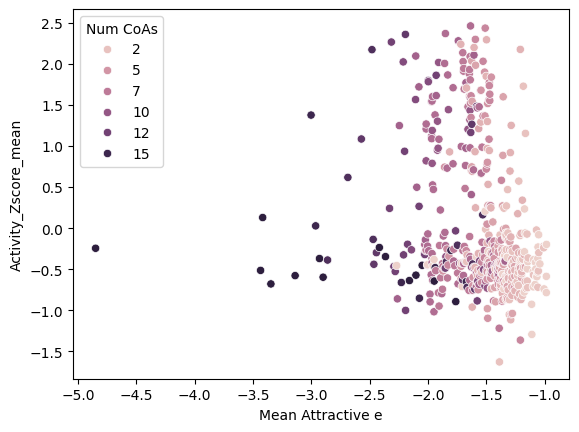

In [160]:
sns.scatterplot(attractiveADs, x = "Mean Attractive e", y = "Activity_Zscore_mean", hue = "Num CoAs")

507   -0.244741
211    0.129276
509   -0.513943
207    0.240891
68    -0.263593
         ...   
388   -0.510817
261    1.837621
463    1.211258
460   -0.477238
121   -0.636957
Name: Activity_Zscore_mean, Length: 305, dtype: float64

In [130]:
Staller5ADlib.loc[attractiveADs.index.to_list()[:20]]

,ADseq,Variant_Name,SystematicName,Activity_Mean_MSS18,Activity_std_MSS18,Biological_Replicate_1_Activity,Biological_Replicate_2_Activity,Biological_Replicate_3_Activity,Biological_Replicate_4_Activity,8_Bin_sort,...,PerturbCharge,PerturbAromatics,CITED2,Stat3,Hif1alpha,p65_L2Y,p65,VP16 H1,CorrectedPvalues_FDR_5percent,SigDiffFromWT
507,TDFWDEEWWMSWWWEMGWDRWKEWPEWWWGQNEFDFMTD,IVL>W,"I223W,V227W,L228W,L231W,V232W,I233W,L237W,I240...",2632.022786,476.231802,2988.395436,2599.731607,1957.857806,2488.222802,2211.067712,...,False,True,True,False,False,False,False,False,0.000176277,TRUE
211,PTDWSWGDEWHWDGEDWAMAHADAWDDFDWDMWGDGDSP,IVL>W,"V418W,L420W,L424W,L426W,V431W,L439W,L444W,L447W",3007.922792,278.144478,2807.872663,3071.432023,2165.688264,3338.638132,2741.144312,...,False,True,False,False,False,False,False,True,0.007015823,TRUE
509,TDFYDEEYYMSYYYEMGYDRYKEYPEYWYGQNEFDFMTD,IVL>Y,"I223Y,V227Y,L228Y,L231Y,V232Y,I233Y,L237Y,I240...",2450.796761,711.539476,3103.285348,1929.674667,2159.864327,1879.808137,2266.512758,...,False,True,True,False,False,False,False,False,0.00177824,TRUE
207,PTDVSLGDEWHLDGEDFDMAHADALDDFDFDMLGDGDSP,supercharge3,"L424W,V431F,A432D,L444F",3353.666919,638.458403,2788.773346,3367.836608,2722.907629,2824.095362,4149.883085,...,False,False,False,False,False,False,False,True,0.011505106,TRUE
68,PGLPNGLLDGDEDFDDIADMDFDALLDQIDD,ST>D,"S529D,S535D,S536D,S543D,S547D,S550D,S551D",2852.467088,445.426992,2245.565518,2628.155432,2343.442165,2703.619373,3426.714385,...,True,False,False,False,False,False,True,False,0.839807296,FALSE
70,PGLPNGLLEGDEDFEEIADMDFEALLEQIEE,ST>E,"S529E,S535E,S536E,S543E,S547E,S550E,S551E",2489.210379,647.010302,3150.788093,2170.808960,1861.298391,2631.430483,1716.887402,...,True,False,False,False,False,False,True,False,0.858045362,FALSE
174,PTDVSLGDELHLDGEDFDMAHFDALDDFDLDMLGDGDSP,supercharge2,"V431F,A432D,A436F",4469.388294,449.010543,3915.154497,4585.430694,3749.320073,4243.221862,4938.975776,...,False,False,False,False,False,False,False,True,0.986528233,FALSE
197,PTDVSLGDELHLDGEDVFFFHFDFLDDFDLDFLGDGDSP,MA>F,"A432F,M433F,A434F,A436F,A438F,M446F",2688.469521,276.408263,2628.609468,2385.618546,2123.678402,2708.461336,2681.141284,...,False,True,False,False,False,False,False,True,0.001449163,TRUE
15,EEEIDLPMEPRELDELMEFGEEGEGAEPEAGGEFEELEFDMELEEE,STQN>E,"S719E,N720E,T721E,S727E,T730E,S733E,Q736E,N739...",2115.230700,945.827948,2992.693649,1470.636777,1681.427256,1177.290150,2339.267099,...,True,False,False,True,False,False,False,False,0.884721242,FALSE
201,PTDVSLGDELHLDGEDVYMYHYDYLDDFDLDMLGDGDSP,A>Y,"A432Y,A434Y,A436Y,A438Y",5383.601973,877.253773,5210.943597,4581.386667,4715.243815,4918.653630,6576.943590,...,False,True,False,False,False,False,False,True,0.030564925,FALSE


In [114]:
#Get top 100 binding ADs from each domain
domain = "P300_TAZ1"
df = staller5libAD_coA_finches_activity.copy()
topnumber = 30

domain_sorted_interaction = df[df["Prot2"] == domain].sort_values("Attractive e", ascending = True)
top_ADs = domain_sorted_interaction["Prot1"][:topnumber]


SyntaxError: invalid syntax (91133129.py, line 2)

In [ ]:
#Can we map interaction strength between AD and CoA to sequence features of the CoA?


In [71]:
ax = sns.kdeplot(staller5libAD_coA_finches_activity, x = "Total e (mf)", y = "Activity_Mean_MSS18", hue = "Prot2", alpha=0.5)


ValueError: Could not interpret value `Activity_Mean_MSS18` for `y`. An entry with this name does not appear in `data`.